## Plotting unitary Fermi gas quantities
Plotting quantities using tabulated data and code from Tilman Enss

In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from general.plot_settings import paper_settings
plt.rcParams.update(paper_settings)

from amo.constants import pi

## Trap distributions

In [ ]:
from amo.unitary_fermi_gas import TrappedUnitaryGas

ToTF = 0.3
EF = 15e3
barnu = 300

TUG = TrappedUnitaryGas(ToTF, EF, barnu, verbose=True)

A trapped unitary gas with EF=15000Hz, T/TF=0.30 and barnu=300Hz
has T=4500Hz, kF=1.09e+07 m^-1, lambda_T=5.94e-07m, mu=6750Hz
tau=1.02e-03s, Ns=20833, Ntotal=41667, Epot=267653396Hz.


c:\Users\colin\Documents\GitHub\chip-lab\ChiPyLab\amo\unitary_fermi_gas.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  return (4*pi)/((3*pi**2)* eos_ufg(betamu))**(2/3)


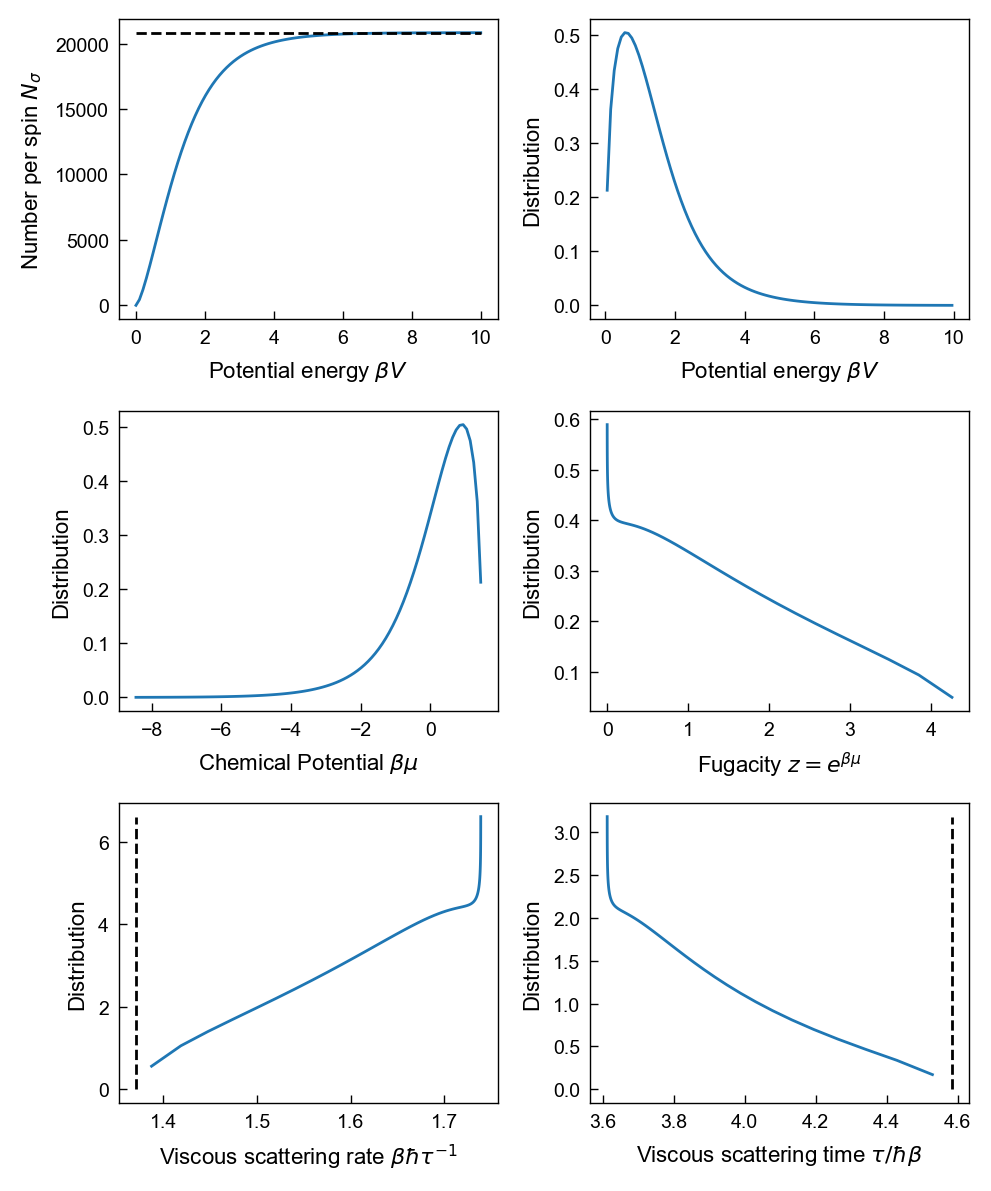

In [ ]:
from amo.unitary_fermi_gas import number_per_spin, betagamma

num = 100
Vmax = 10*TUG.T
Vs_edges = np.linspace(0, Vmax, num)

Ns_cdf = np.array([number_per_spin(TUG.betamu, TUG.betabaromega, 
                                  v_max=V/TUG.T) for V in Vs_edges])

Vs = Vs_edges[:-1] + np.diff(Vs_edges)/2  # Mid points
V_pdf = np.diff(Ns_cdf)
norm = np.trapezoid(V_pdf, dx=Vmax/num/TUG.T)
V_pdf /= norm

xlabel = r'Potential energy $\beta V$'
ylabel = r'Number per spin $N_\sigma$'

fig, axes = plt.subplots(3,2, figsize=(5,6))
axs = axes.flatten()
# fig.suptitle("CDF of atoms in a trapped unitary Fermi gas", fontsize=8)

ax = axs[0]
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(Vs_edges/TUG.T, Ns_cdf)
ax.hlines(TUG.Ns, 0, Vmax/TUG.T, linestyle='--', color='k')

ylabel = r'Distribution'

ax = axs[1]
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(Vs/TUG.T, V_pdf)
# ax.vlines(TUG.Ns, 0, Vmax/EF, linestyle='--', color='k')


### Chemical potential
mus = TUG.betamu - Vs/TUG.T
mu_pdf = V_pdf

xlabel = r'Chemical Potential $\beta\mu$'
ylabel = r'Distribution'

ax = axs[2]
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(mus, mu_pdf)


### Fugacity
zs = np.exp(mus)
z_jacobian = 1/zs
z_pdf = V_pdf * z_jacobian

xlabel = r'Fugacity $z=e^{\beta\mu}$'
ax = axs[3]
ax.set(xlabel=xlabel, ylabel=ylabel)#, xscale='log')
ax.plot(zs, z_pdf)


### gamma
gammas = betagamma(zs)
gamma_jacobian = 1/0.0892  # Ignoring quadratic term.
gamma_pdf = z_pdf * gamma_jacobian

# np.trapezoid(Ns_pdf/z_pdf*gamma_jacobian, x=gamma_pdf)

xlabel = r'Viscous scattering rate $\beta\hbar \tau^{-1}$'
ylabel = r'Distribution'

ax = axs[4]
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(gammas, gamma_pdf)
ax.vlines(TUG.gamma/TUG.T, 0, np.max(gamma_pdf), linestyle='--', color='k')


### tau
taus = 1/gammas * 2*pi
tau_jacobian = lambda tau: 1/tau**2 * 2*pi
tau_pdf = gamma_pdf * tau_jacobian(taus)

xlabel = r'Viscous scattering time $\tau/\hbar\beta$'
ax = axs[5]
ax.set(xlabel=xlabel, ylabel=ylabel)#, xscale='log')
ax.plot(taus, tau_pdf)
ax.vlines(TUG.tau * TUG.T, 0, np.max(tau_pdf), linestyle='--', color='k')

fig.tight_layout()
plt.show()

In [ ]:
TUG.T
TUG.tau/2/pi

np.float64(0.00016213830486688866)

In [ ]:
print("Checking spectrum normalizations (ignore negative signs).")
print("Potential", np.trapezoid(V_pdf, x=Vs/TUG.T))
print("Chemical potential mu", np.trapezoid(mu_pdf, x=mus))
print("Fugacity z", np.trapezoid(z_pdf, x=zs))
print("Viscous scattering rate, beta gamma", np.trapezoid(gamma_pdf, x=gammas))
print("Viscous scattering time, tau/beta", np.trapezoid(tau_pdf, x=taus))

Checking spectrum normalizations (ignore negative signs).
Potential 1.01010101010101
Chemical potential mu -1.01010101010101
Fugacity z -1.011276031330941
Viscous scattering rate, beta gamma 0.9552125167423485
Viscous scattering time, tau/beta -0.955820323342024


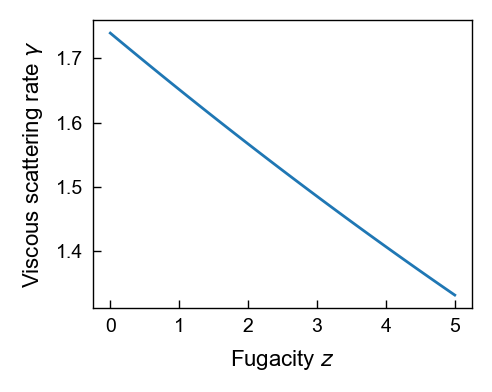

In [ ]:
fig, ax = plt.subplots(figsize=(2.5,2))

xlabel = r'Fugacity $z$'
ylabel = r'Viscous scattering rate $\gamma$'
ax.set(xlabel=xlabel, ylabel=ylabel)
z = np.linspace(0, 5, 100)
ax.plot(z, betagamma(z))
fig.tight_layout()
plt.show()

### Contact density
From Enss, Haussmann, Zwerger 2011?

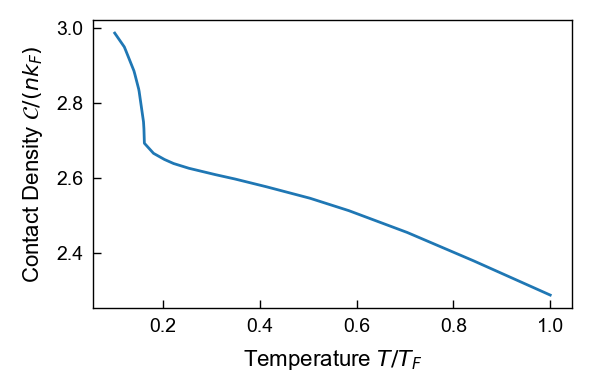

In [ ]:
from amo.luttinger_ward_calculations import contact_density

ToTFs = np.linspace(0.1, 1.0, 1000)

xlabel = r'Temperature $T/T_F$'
ylabel = r'Contact Density $\mathcal{C}/(n k_F)$'

fig, ax = plt.subplots(figsize=(3,2))

ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(ToTFs, 3*pi**2*contact_density(ToTFs))

fig.tight_layout()

plt.show()


### Trap-averaged contact and contact slope

In [ ]:
from amo.unitary_fermi_gas import trap_averaged_contact, \
        trap_averaged_contact_slope

ToTFs = np.linspace(0.1, 1.0, 50)
EF = 10e3  # Hz
barnu = 300  # Hz

Cs = np.array([trap_averaged_contact(*arg) for arg in zip(ToTFs, 
        EF * np.ones_like(ToTFs), barnu * np.ones_like(ToTFs))])

Ss = np.array([trap_averaged_contact_slope(*arg) for arg in zip(ToTFs, 
        EF * np.ones_like(ToTFs), barnu * np.ones_like(ToTFs))])


c:\Users\colin\Documents\GitHub\chip-lab\ChiPyLab\amo\unitary_fermi_gas.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  return (4*pi)/((3*pi**2)* eos_ufg(betamu))**(2/3)


In [ ]:
# Load trap-averaged S from Tilman data
import pandas as pd

# columns:  T/T_F S_TF S_Gauss S_min_both
# S in units (kFa)^2/E_F
S_avg_file = 'sumruleavg.txt'
df_S_avg = pd.read_csv(os.path.join('..', 'data', S_avg_file), skiprows=2, sep=' ')
x_label = 'T/T_F'
S_avg_labels = ['S_TF', 'S_Gauss', 'S_min_both']

def trap_avg_S(ToTF, S_avg_label='S_min_both'):
    """Functions that interpolates trap-averaged (k_F a)^2 S/(E_F) using
       tabulated data from Tilman"""
    return 18*pi*np.interp(ToTF, df_S_avg[x_label], df_S_avg[S_avg_label])

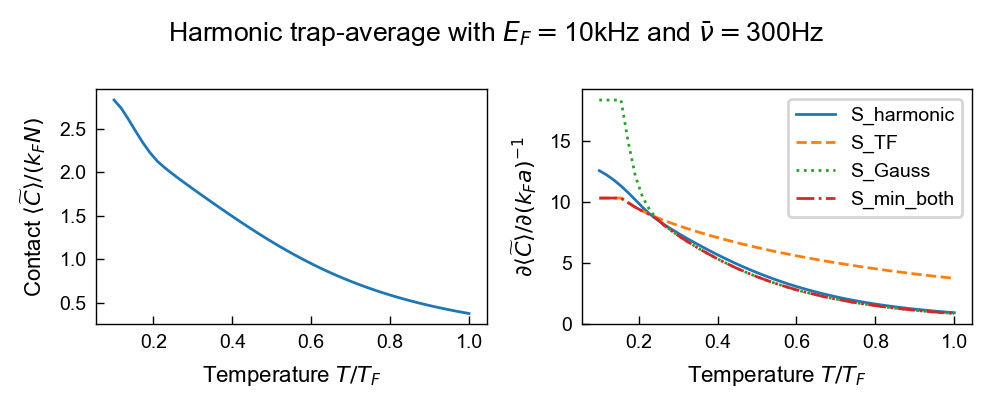

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(5,2))
fig.suptitle(r"Harmonic trap-average with $E_F=$" + f"{EF/1e3:.0f}kHz" \
             + r" and $\bar\nu=$" + f"{barnu:.0f}Hz")

## Trap-averaged contact
ax = axs[0]
xlabel = r'Temperature $T/T_F$'
ylabel = r'Contact $\langle \widetilde{C} \rangle/(k_F N)$'

ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(ToTFs, Cs)

## Trap-averaged contact slope
ax = axs[1]
xlabel = r'Temperature $T/T_F$'
ylabel = r'$\partial\langle \widetilde{C} \rangle/\partial(k_F a)^{-1}$'

ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(ToTFs, Ss, label='S_harmonic')

linestyles = ['--', ':', '-.']
for S_avg_label, ls in zip(S_avg_labels, linestyles):
    ax.plot(ToTFs, trap_avg_S(ToTFs, S_avg_label=S_avg_label), ls,
            label=S_avg_label)
ax.legend(fontsize=7)
# ax.set(xlim=[0.25, 0.5], ylim=[3, 10])

fig.tight_layout()
plt.show()